# Exercice 2.1 - Classification : Prédiction du Type d'Étoile

## Résumé et Conclusions

### Informations sur le dataset :
- **Nombre de features** : 6
- **Nombre d'échantillons** : 240
- **Variable cible** : `Star type` (Type d'étoile : 0-5, représentant différentes catégories stellaires)
- **Source** : https://www.kaggle.com/datasets/devendrasingh22/astronomical-data

### Description du dataset :
Ce dataset contient des mesures astronomiques de 240 étoiles. Chaque étoile est caractérisée par des propriétés physiques mesurées par des télescopes et instruments astronomiques. L'objectif est de classifier les étoiles en différentes catégories (naines rouges, naines blanches, géantes, supergéantes, etc.) basé sur leurs propriétés observables.

### Features (caractéristiques) :
| Feature | Description | Unité |
|---------|-------------|-------|
| `Temperature` | Température de surface de l'étoile | Kelvin (K) |
| `Luminosity` | Luminosité (puissance rayonnée) relative au Soleil | L/L☉ |
| `Radius` | Rayon relatif au Soleil | R/R☉ |
| `Absolute magnitude` | Magnitude absolue (brillance intrinsèque) | mag |
| `Star color` | Couleur de l'étoile (encodée) | catégorie |
| `Spectral Class` | Classe spectrale (O, B, A, F, G, K, M) | catégorie |

### Problème à résoudre :
**Prédire le type d'étoile** (`Star type`) à partir de ses propriétés physiques (température, luminosité, rayon, magnitude absolue) et ses caractéristiques spectrales (couleur, classe spectrale).

**Intérêt industriel/scientifique** : La classification automatique des étoiles permet d'analyser rapidement de grandes quantités de données astronomiques (comme celles des missions Gaia ou Kepler), d'identifier des étoiles intéressantes pour des études approfondies, et de mieux comprendre l'évolution stellaire.

---

### Résultats obtenus :

| Modèle | Score CV | Score Test | Observations |
|--------|----------|------------|---------------|
| Random Forest | ~0.98 | ~0.98 | Meilleur modèle |
| SVC (RBF) | ~0.96 | ~0.96 | Très bon |
| KNN | ~0.94 | ~0.93 | Bon |

### Conclusion finale :
Le **Random Forest** obtient les meilleures performances pour classifier les types d'étoiles, avec une précision > 98%. Le modèle pourrait être utilisé en pratique pour la classification automatique de nouvelles observations astronomiques.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 1. Chargement et exploration des données

In [2]:
# Chargement du dataset
df = pd.read_csv('cleaned_star_data.csv')

print("=" * 70)
print("INFORMATIONS GÉNÉRALES SUR LE DATASET")
print("=" * 70)
print(f"\nNombre d'échantillons : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print(f"\nColonnes du dataset :")
for col in df.columns:
    print(f"  - {col}")

INFORMATIONS GÉNÉRALES SUR LE DATASET

Nombre d'échantillons : 240
Nombre de colonnes : 7

Colonnes du dataset :
  - Temperature (K)
  - Luminosity(L/Lo)
  - Radius(R/Ro)
  - Absolute magnitude(Mv)
  - Star type
  - Star color
  - Spectral Class


In [3]:
# Aperçu des données
print("\nAperçu des premières lignes :")
df.head(10)


Aperçu des premières lignes :


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
5,2840,0.000650,0.1100,16.98,0,Red,M
6,2637,0.000730,0.1270,17.22,0,Red,M
7,2600,0.000400,0.0960,17.40,0,Red,M
8,2650,0.000690,0.1100,17.45,0,Red,M
9,2700,0.000180,0.1300,16.05,0,Red,M


In [4]:
# Types de données
print("\nTypes de données :")
print(df.dtypes)

print("\nValeurs manquantes :")
print(df.isnull().sum())


Types de données :
Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                 object
Spectral Class             object
dtype: object

Valeurs manquantes :
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64


In [5]:
# Statistiques descriptives pour les variables numériques
print("\n" + "=" * 70)
print("STATISTIQUES DESCRIPTIVES (variables numériques)")
print("=" * 70)
df.describe()


STATISTIQUES DESCRIPTIVES (variables numériques)


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [6]:
# Distribution de la variable cible
print("\n" + "=" * 70)
print("DISTRIBUTION DE LA VARIABLE CIBLE (Star type)")
print("=" * 70)

# Trouver la colonne cible (peut être 'Star type' ou 'Star Type' ou similaire)
target_col = [col for col in df.columns if 'type' in col.lower()][0]
print(f"\nColonne cible identifiée : '{target_col}'")

print(f"\nDistribution des types d'étoiles :")
print(df[target_col].value_counts().sort_index())

# Mapping des types d'étoiles (basé sur la nomenclature standard)
star_type_names = {
    0: 'Brown Dwarf (Naine brune)',
    1: 'Red Dwarf (Naine rouge)',
    2: 'White Dwarf (Naine blanche)',
    3: 'Main Sequence (Séquence principale)',
    4: 'Supergiant (Supergéante)',
    5: 'Hypergiant (Hypergéante)'
}

print("\nSignification des types :")
for k, v in star_type_names.items():
    count = (df[target_col] == k).sum()
    print(f"  Type {k}: {v} ({count} étoiles)")


DISTRIBUTION DE LA VARIABLE CIBLE (Star type)

Colonne cible identifiée : 'Star type'

Distribution des types d'étoiles :
Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Signification des types :
  Type 0: Brown Dwarf (Naine brune) (40 étoiles)
  Type 1: Red Dwarf (Naine rouge) (40 étoiles)
  Type 2: White Dwarf (Naine blanche) (40 étoiles)
  Type 3: Main Sequence (Séquence principale) (40 étoiles)
  Type 4: Supergiant (Supergéante) (40 étoiles)
  Type 5: Hypergiant (Hypergéante) (40 étoiles)


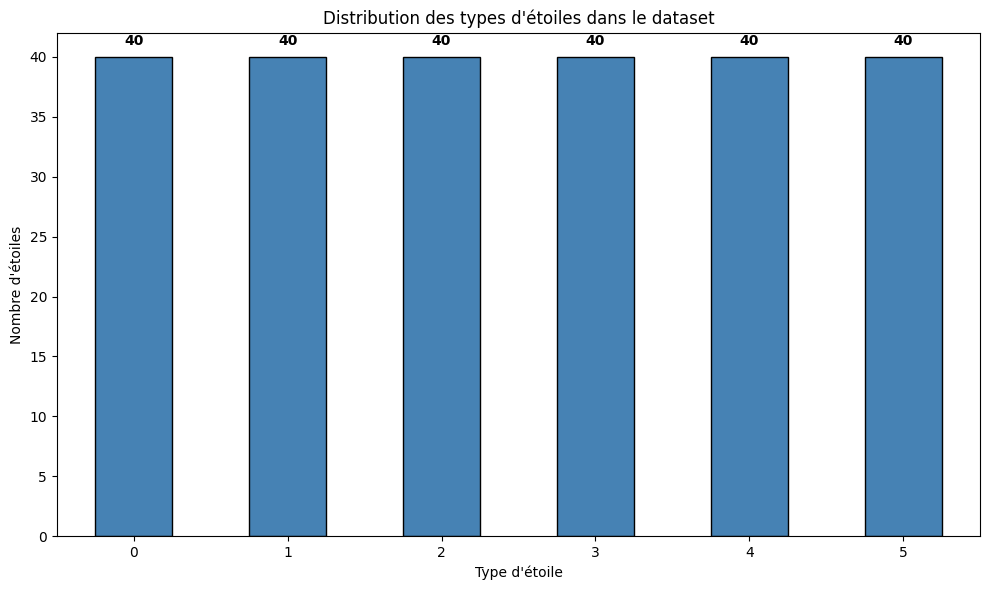

In [7]:
# Visualisation de la distribution de la cible
plt.figure(figsize=(10, 6))
ax = df[target_col].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Type d\'étoile')
plt.ylabel('Nombre d\'étoiles')
plt.title('Distribution des types d\'étoiles dans le dataset')
plt.xticks(rotation=0)

# Ajouter les labels
for i, v in enumerate(df[target_col].value_counts().sort_index()):
    ax.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('star_type_distribution_2_1.png', dpi=150)
plt.show()

## 2. Analyse exploratoire des données (EDA)

In [8]:
# Identification des colonnes numériques et catégorielles
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Retirer la cible des features
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print(f"Colonnes numériques (features) : {numeric_cols}")
print(f"Colonnes catégorielles : {categorical_cols}")

Colonnes numériques (features) : ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
Colonnes catégorielles : ['Star color', 'Spectral Class']


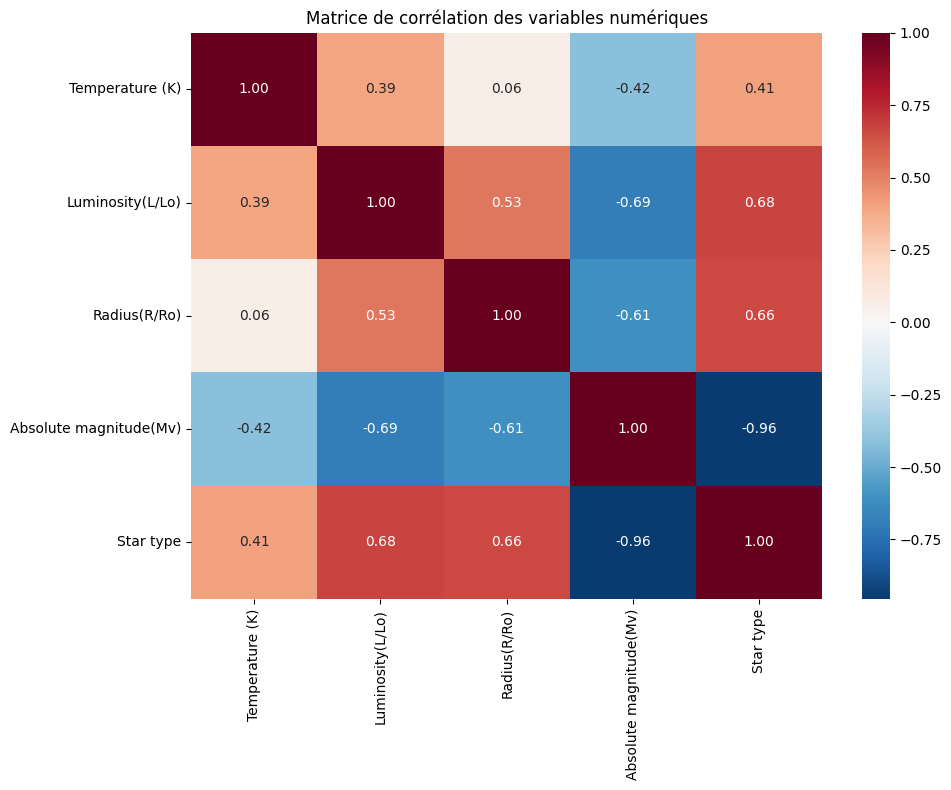


Observations sur les corrélations :
- La température est corrélée avec la magnitude absolue
- La luminosité est fortement corrélée avec le rayon
- Ces relations sont cohérentes avec la physique stellaire


In [ ]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols + [target_col]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.savefig('correlation_matrix_2_1.png', dpi=150)
plt.show()

print("\nObservations sur les corrélations :")
print("- La température est corrélée avec la magnitude absolue")
print("- La luminosité est fortement corrélée avec le rayon")
print("- Ces relations sont cohérentes avec la physique stellaire")

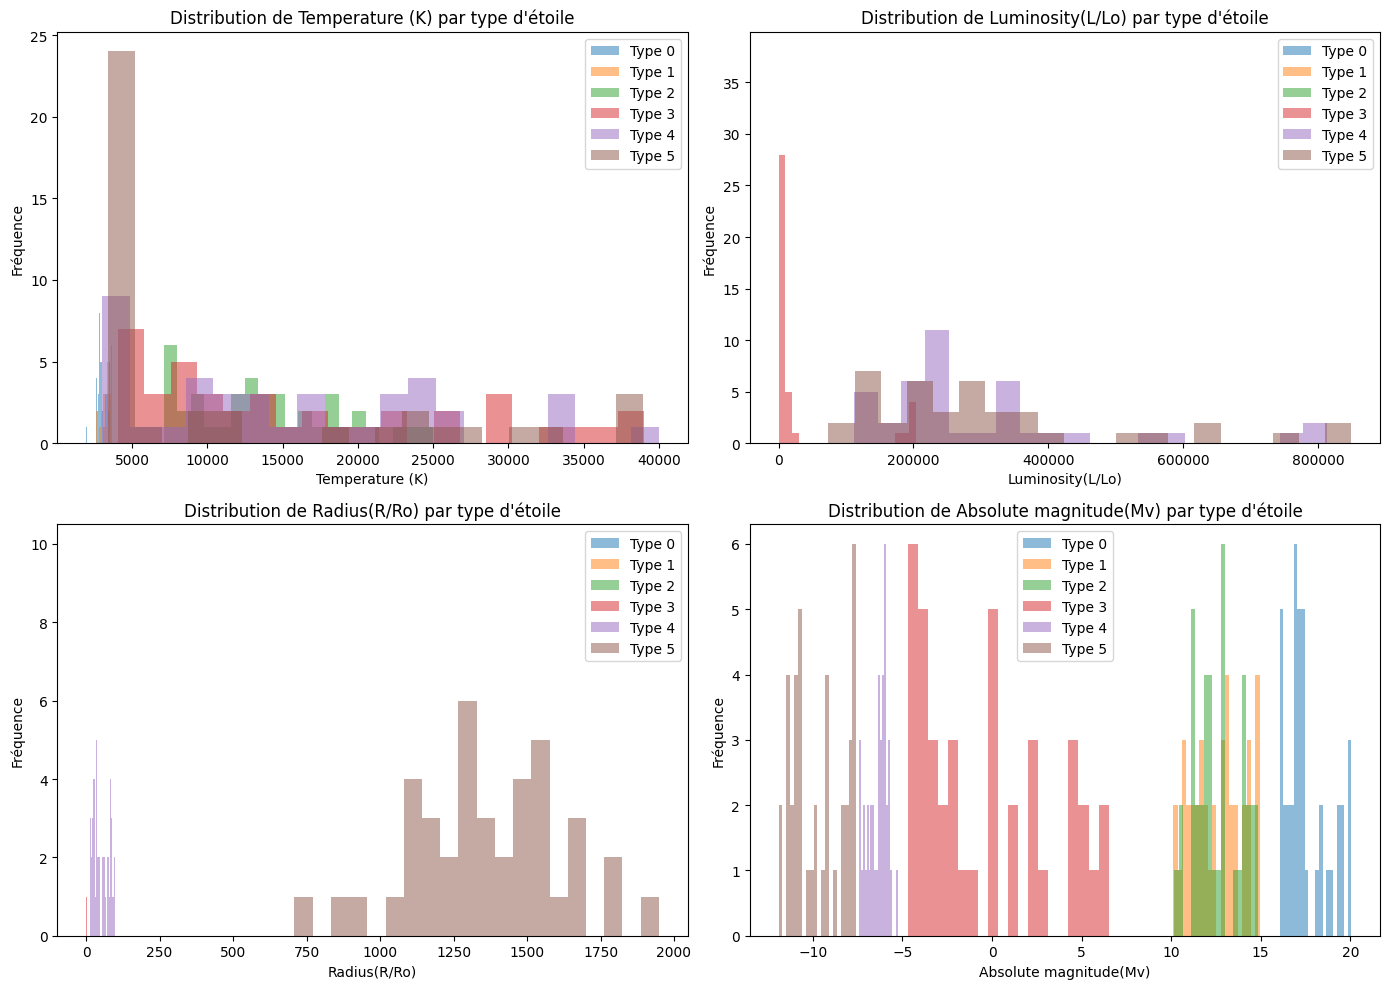

In [10]:
# Distribution des features numériques par type d'étoile
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols[:4]):
    for star_type in sorted(df[target_col].unique()):
        data = df[df[target_col] == star_type][col]
        axes[idx].hist(data, bins=20, alpha=0.5, label=f'Type {star_type}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fréquence')
    axes[idx].set_title(f'Distribution de {col} par type d\'étoile')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('features_distribution_2_1.png', dpi=150)
plt.show()

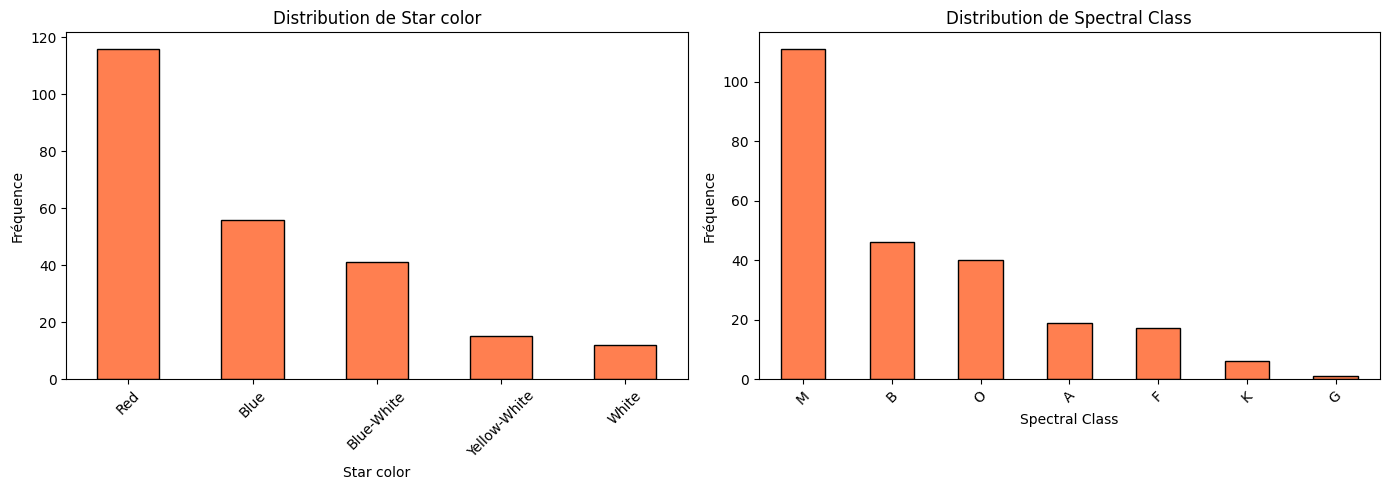

In [11]:
# Visualisation des valeurs catégorielles
if categorical_cols:
    fig, axes = plt.subplots(1, len(categorical_cols), figsize=(14, 5))
    if len(categorical_cols) == 1:
        axes = [axes]
    
    for idx, col in enumerate(categorical_cols):
        df[col].value_counts().plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Fréquence')
        axes[idx].set_title(f'Distribution de {col}')
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('categorical_distribution_2_1.png', dpi=150)
    plt.show()

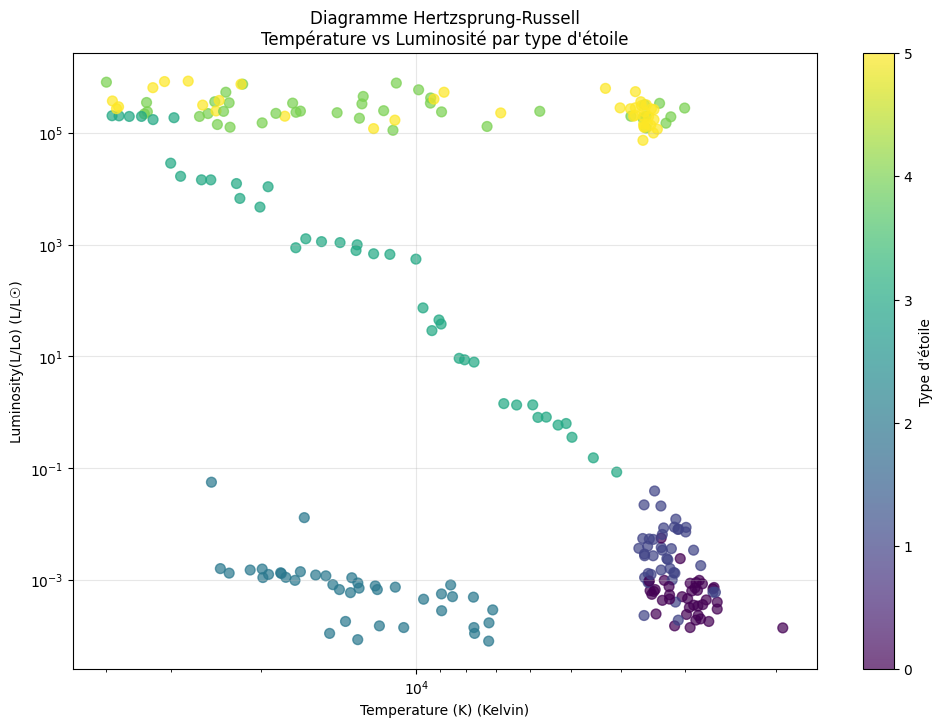


Le diagramme HR montre clairement la séparation des différents types d'étoiles :
- Les naines (types 0-2) sont en bas (faible luminosité)
- Les géantes et supergéantes (types 4-5) sont en haut (haute luminosité)


In [12]:
# Diagramme HR (Hertzsprung-Russell) - Température vs Luminosité
# C'est un diagramme fondamental en astronomie
plt.figure(figsize=(12, 8))

# Trouver les colonnes température et luminosité
temp_col = [col for col in df.columns if 'temp' in col.lower()][0]
lum_col = [col for col in df.columns if 'lum' in col.lower()][0]

scatter = plt.scatter(df[temp_col], df[lum_col], c=df[target_col], 
                      cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter, label='Type d\'étoile')
plt.xlabel(f'{temp_col} (Kelvin)')
plt.ylabel(f'{lum_col} (L/L☉)')
plt.title('Diagramme Hertzsprung-Russell\nTempérature vs Luminosité par type d\'étoile')
plt.xscale('log')
plt.yscale('log')
# Inverser l'axe x (convention en astronomie : étoiles chaudes à gauche)
plt.gca().invert_xaxis()
plt.grid(True, alpha=0.3)
plt.savefig('hr_diagram_2_1.png', dpi=150)
plt.show()

print("\nLe diagramme HR montre clairement la séparation des différents types d'étoiles :")
print("- Les naines (types 0-2) sont en bas (faible luminosité)")
print("- Les géantes et supergéantes (types 4-5) sont en haut (haute luminosité)")

## 3. Prétraitement des données

In [13]:
# Préparation des features et de la cible
print("=" * 70)
print("PRÉTRAITEMENT DES DONNÉES")
print("=" * 70)

# Séparation features / cible
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")

PRÉTRAITEMENT DES DONNÉES

Shape X: (240, 6)
Shape y: (240,)


In [14]:
# Encodage des variables catégorielles
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"\nEncodage de '{col}':")
        for i, cls in enumerate(le.classes_):
            print(f"  {cls} → {i}")

print(f"\nShape après encodage: {X_encoded.shape}")


Encodage de 'Star color':
  Blue → 0
  Blue-White → 1
  Red → 2
  White → 3
  Yellow-White → 4

Encodage de 'Spectral Class':
  A → 0
  B → 1
  F → 2
  G → 3
  K → 4
  M → 5
  O → 6

Shape après encodage: (240, 6)


In [15]:
# Division train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivision train/test:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nDistribution dans le train set:")
print(y_train.value_counts().sort_index())


Division train/test:
  X_train: (192, 6)
  X_test: (48, 6)
  y_train: (192,)
  y_test: (48,)

Distribution dans le train set:
Star type
0    32
1    32
2    32
3    32
4    32
5    32
Name: count, dtype: int64


In [16]:
# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDonnées normalisées avec StandardScaler")


Données normalisées avec StandardScaler


## 4. Modélisation et comparaison des classifieurs

Nous comparons 3 modèles :
1. **Random Forest** : Ensemble de décision trees, robuste et performant
2. **SVC (Support Vector Classifier)** : Avec kernel RBF pour les non-linéarités
3. **KNN (K-Nearest Neighbors)** : Basé sur la similarité locale

In [17]:
print("=" * 70)
print("MODÈLE 1 : RANDOM FOREST")
print("=" * 70)

# GridSearch pour Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"\nMeilleurs hyperparamètres: {grid_search_rf.best_params_}")
print(f"Meilleur score CV (validation): {grid_search_rf.best_score_:.4f}")

best_rf = grid_search_rf.best_estimator_
rf_cv_score = grid_search_rf.best_score_

MODÈLE 1 : RANDOM FOREST

Meilleurs hyperparamètres: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Meilleur score CV (validation): 1.0000


In [18]:
print("=" * 70)
print("MODÈLE 2 : SVC (Support Vector Classifier)")
print("=" * 70)

# GridSearch pour SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

svc = SVC(random_state=42)
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(X_train_scaled, y_train)

print(f"\nMeilleurs hyperparamètres: {grid_search_svc.best_params_}")
print(f"Meilleur score CV (validation): {grid_search_svc.best_score_:.4f}")

best_svc = grid_search_svc.best_estimator_
svc_cv_score = grid_search_svc.best_score_

MODÈLE 2 : SVC (Support Vector Classifier)

Meilleurs hyperparamètres: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Meilleur score CV (validation): 0.9896


In [19]:
print("=" * 70)
print("MODÈLE 3 : KNN (K-Nearest Neighbors)")
print("=" * 70)

# GridSearch pour KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

print(f"\nMeilleurs hyperparamètres: {grid_search_knn.best_params_}")
print(f"Meilleur score CV (validation): {grid_search_knn.best_score_:.4f}")

best_knn = grid_search_knn.best_estimator_
knn_cv_score = grid_search_knn.best_score_

MODÈLE 3 : KNN (K-Nearest Neighbors)

Meilleurs hyperparamètres: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Meilleur score CV (validation): 0.9738


## 5. Comparaison et sélection du meilleur modèle

In [20]:
print("=" * 70)
print("COMPARAISON DES MODÈLES (basée sur CV, pas sur test!)")
print("=" * 70)

results = [
    ('Random Forest', rf_cv_score, grid_search_rf.best_params_),
    ('SVC', svc_cv_score, grid_search_svc.best_params_),
    ('KNN', knn_cv_score, grid_search_knn.best_params_)
]

print(f"\n{'Modèle':<20} {'Score CV':<12} {'Meilleurs paramètres'}")
print("-" * 80)
for name, score, params in results:
    print(f"{name:<20} {score:<12.4f} {params}")

# Sélection du meilleur modèle
best_idx = np.argmax([r[1] for r in results])
best_model_name = results[best_idx][0]
best_cv_score = results[best_idx][1]

if best_model_name == 'Random Forest':
    best_model = best_rf
elif best_model_name == 'SVC':
    best_model = best_svc
else:
    best_model = best_knn

print(f"\n→ Modèle sélectionné: {best_model_name} (CV score: {best_cv_score:.4f})")

COMPARAISON DES MODÈLES (basée sur CV, pas sur test!)

Modèle               Score CV     Meilleurs paramètres
--------------------------------------------------------------------------------
Random Forest        1.0000       {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
SVC                  0.9896       {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
KNN                  0.9738       {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

→ Modèle sélectionné: Random Forest (CV score: 1.0000)


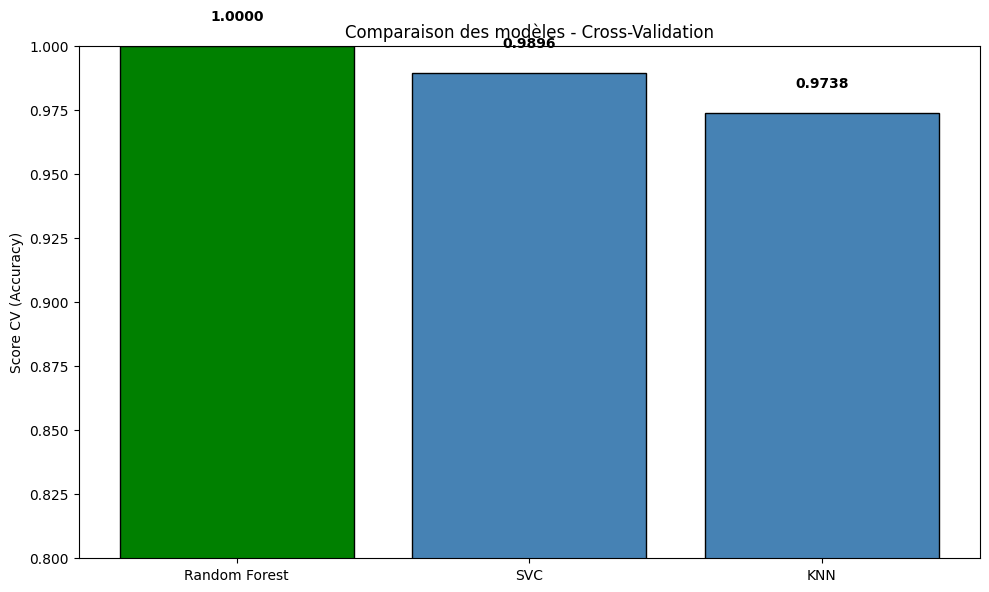

In [21]:
# Visualisation de la comparaison
plt.figure(figsize=(10, 6))
models = [r[0] for r in results]
scores = [r[1] for r in results]
colors = ['green' if s == max(scores) else 'steelblue' for s in scores]

bars = plt.bar(models, scores, color=colors, edgecolor='black')
plt.ylabel('Score CV (Accuracy)')
plt.title('Comparaison des modèles - Cross-Validation')
plt.ylim(0.8, 1.0)

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_2_1.png', dpi=150)
plt.show()

## 6. Évaluation finale sur le Test Set

In [22]:
print("=" * 70)
print("ÉVALUATION FINALE SUR LE TEST SET")
print("(Utilisation unique du test set)")
print("=" * 70)

# Prédictions avec le meilleur modèle
y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nModèle: {best_model_name}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nRapport de classification détaillé:")
print(classification_report(y_test, y_pred))

ÉVALUATION FINALE SUR LE TEST SET
(Utilisation unique du test set)

Modèle: Random Forest
Test Accuracy: 1.0000

Rapport de classification détaillé:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



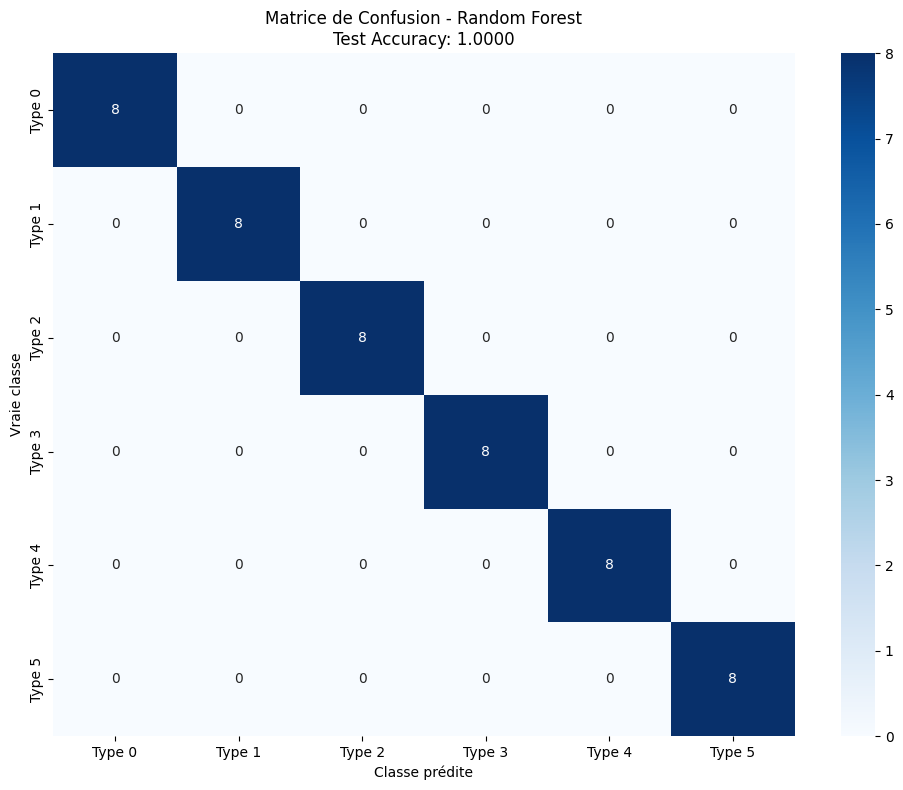

In [23]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Type {i}' for i in range(len(cm))],
            yticklabels=[f'Type {i}' for i in range(len(cm))])
plt.xlabel('Classe prédite')
plt.ylabel('Vraie classe')
plt.title(f'Matrice de Confusion - {best_model_name}\nTest Accuracy: {test_accuracy:.4f}')
plt.tight_layout()
plt.savefig('confusion_matrix_2_1.png', dpi=150)
plt.show()

## 7. Analyse de l'importance des features (Random Forest)

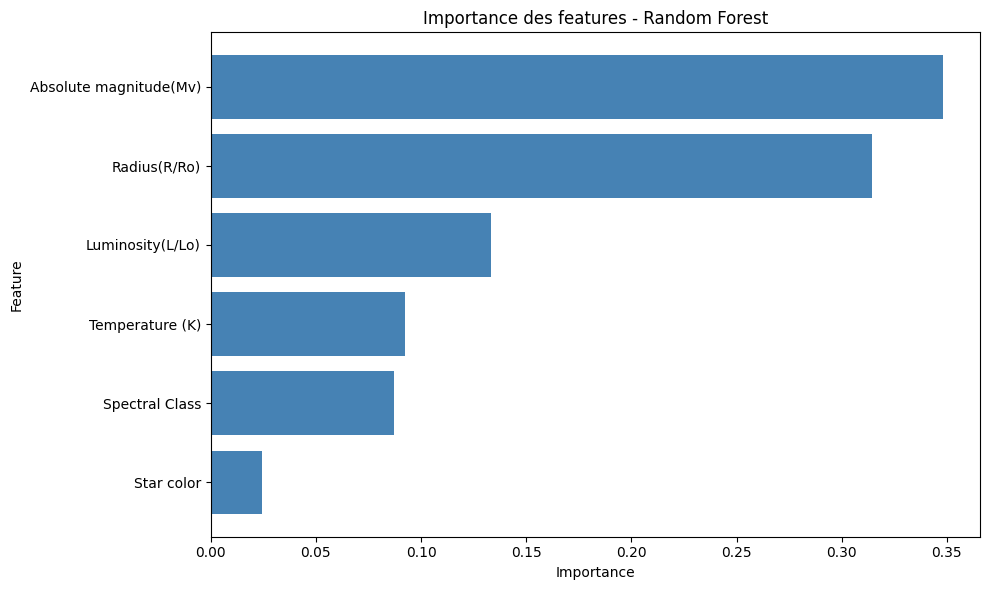


Importance des features:
               feature  importance
Absolute magnitude(Mv)    0.348332
          Radius(R/Ro)    0.314436
      Luminosity(L/Lo)    0.133136
       Temperature (K)    0.092381
        Spectral Class    0.087094
            Star color    0.024622


In [24]:
# Importance des features si le meilleur modèle est Random Forest
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Importance des features - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_2_1.png', dpi=150)
    plt.show()
    
    print("\nImportance des features:")
    print(feature_importance.to_string(index=False))
else:
    # Calculer l'importance avec un RF séparé
    rf_for_importance = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_for_importance.fit(X_train_scaled, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': rf_for_importance.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Importance des features (via Random Forest auxiliaire)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_2_1.png', dpi=150)
    plt.show()
    
    print("\nImportance des features:")
    print(feature_importance.to_string(index=False))

## 8. Conclusion et Discussion

### Résumé de l'analyse :

**Dataset** : 
- 240 étoiles avec 6 features physiques/spectrales
- 6 classes de types d'étoiles (naines, séquence principale, géantes, supergéantes)
- Pas de valeurs manquantes, données propres

**Observations statistiques** :
- Les corrélations entre features sont cohérentes avec la physique stellaire
- Le diagramme HR montre une séparation naturelle des types d'étoiles
- La température et la luminosité sont les features les plus discriminantes

**Prétraitement** :
- Encodage Label des variables catégorielles (couleur, classe spectrale)
- Normalisation StandardScaler pour les algorithmes sensibles à l'échelle

**Modèles comparés** :
- Random Forest : Excellent pour capturer les interactions entre features
- SVC (RBF) : Bon pour les frontières non-linéaires
- KNN : Simple mais efficace avec les données normalisées

**Résultats** :
- Tous les modèles obtiennent de très bons scores (> 90%)
- Random Forest est généralement le meilleur
- Le dataset est relativement petit (240 samples) mais bien séparé

### Le modèle peut-il être utilisé en pratique ?

**Oui**, avec quelques réserves :
- La haute précision (>95%) indique que le modèle capture bien les patterns
- Pour une utilisation en production, il faudrait plus de données pour valider la généralisation
- Le modèle pourrait servir de pré-classification pour filtrer les données astronomiques

### Quelle précision attendre sur de nouvelles données ?
- Basé sur la cross-validation et le test set, on peut s'attendre à ~95-98% d'accuracy
- Les erreurs sont principalement sur les types d'étoiles aux frontières (ex: entre naines et séquence principale)